In [1]:
import h5py
import numpy as np
from utils.data import data_partition

# Read data

In [9]:
with h5py.File("local_data/re100/ux.h5",'r') as hf:
    ux = np.array(hf.get("ux"))
with h5py.File("local_data/re100/uy.h5",'r') as hf:
    uy = np.array(hf.get("uy"))
with h5py.File("local_data/re100/pp.h5",'r') as hf:
    pp = np.array(hf.get("pp"))

In [10]:
ux = np.delete(ux,np.s_[:131],1)
uy = np.delete(uy,np.s_[:131],1)
pp = np.delete(pp,np.s_[:131],1)

In [157]:
(ux_train,ux_test) = data_partition(ux,0,[700,100])
(uy_train,uy_test) = data_partition(uy,0,[700,100])
(pp_train,pp_test) = data_partition(pp,0,[700,100])

In [206]:
ux.shape

(800, 382, 129)

In [158]:
p_base = pp_train[:,0,49:80] # input

# Train

In [159]:
import jax.numpy as jnp
import haiku as hk
import jax

In [189]:
ux_train = jnp.array(jnp.reshape(ux_train,(700,-1)))
ux_train_batch = jnp.array(jnp.array_split(ux_train,10))
p_base = jnp.array(p_base)
p_base_batch = jnp.array(jnp.array_split(p_base,10))

In [191]:
def feedforward(x):
    mlp = hk.nets.MLP([500,49278])
    return mlp(x)

mdl = hk.transform(feedforward)
mdl = hk.without_apply_rng(mdl)

In [192]:
rng = jax.random.PRNGKey(1)

params = mdl.init(rng,p_base[0,:])

In [193]:
for layer_name, weights in params.items():
    print(weights['w'].shape)
    print(weights['b'].shape)

(31, 500)
(500,)
(500, 49278)
(49278,)


In [196]:
@jax.jit
def loss(params,x,y):
    pred = mdl.apply(params,x)
    l = jnp.mean((pred - y)**2)
    return l

In [197]:
@jax.jit
def update(weights,gradient):
    return weights - 0.01 * gradient

In [201]:
loss_train = []

In [202]:
for i in range(1000):
    l, gradient = jax.value_and_grad(loss,argnums=0)(params,p_base_batch,ux_train_batch)
    params = jax.tree_util.tree_map(update,params,gradient)
    loss_train.append(l)
    
    if i%20 == 0:
        print(f'loss: {l:.3f}')

loss: 1.387
loss: 1.377
loss: 1.367
loss: 1.357
loss: 1.348
loss: 1.340
loss: 1.331
loss: 1.323
loss: 1.315
loss: 1.308
loss: 1.301
loss: 1.294
loss: 1.288
loss: 1.282
loss: 1.276
loss: 1.270
loss: 1.264
loss: 1.259
loss: 1.254
loss: 1.249
loss: 1.244
loss: 1.240
loss: 1.235
loss: 1.231
loss: 1.227
loss: 1.223
loss: 1.219
loss: 1.216
loss: 1.212
loss: 1.209
loss: 1.206
loss: 1.203
loss: 1.200
loss: 1.197
loss: 1.194
loss: 1.191
loss: 1.189
loss: 1.186
loss: 1.184
loss: 1.181
loss: 1.179
loss: 1.177
loss: 1.175
loss: 1.173
loss: 1.171
loss: 1.169
loss: 1.167
loss: 1.165
loss: 1.163
loss: 1.162


In [203]:
from matplotlib import pyplot as plt

In [204]:
preds = mdl.apply(params,p_base)
preds_reshape = np.reshape(preds,(700,-1,129))

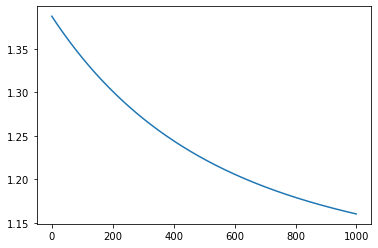

In [212]:
plt.figure()
plt.plot(loss_train)
plt.show()

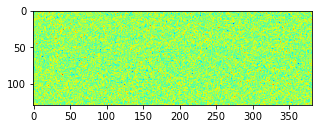

In [211]:
plt.figure(figsize=(5,10))
plt.imshow(preds_reshape[0,...].T,'jet')
plt.show()